In [60]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import cv2
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

> Dataset: https://www.kaggle.com/datasets/uraninjo/augmented-alzheimer-mri-dataset

# Visualize

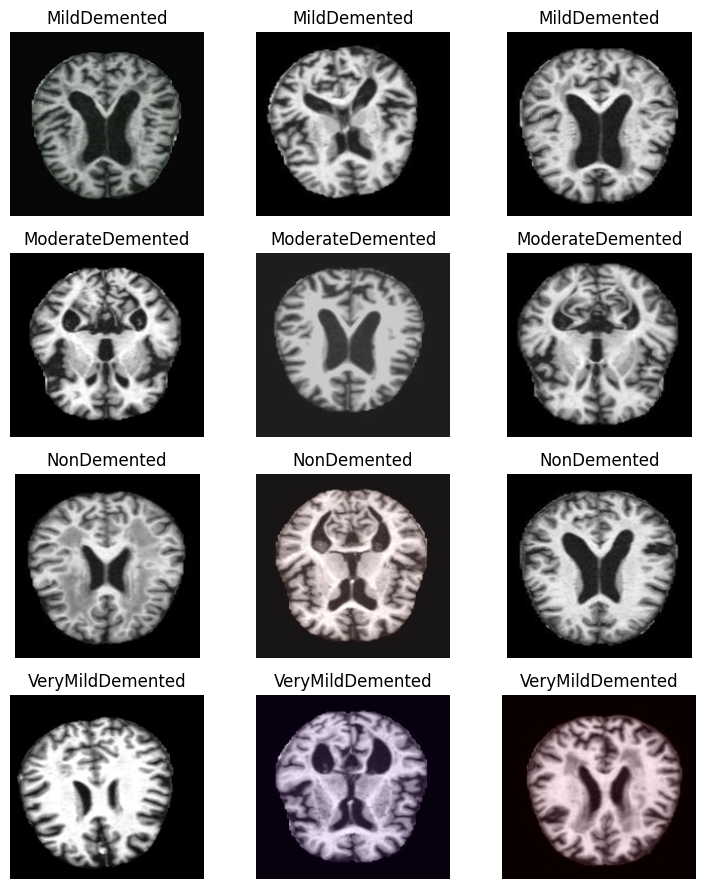

In [61]:
data = Path("../../Data/AugmentedAlzheimerDataset")
imgs = list(data.rglob("*.jpg"))

# Plot images
fig, axs = plt.subplots(4, 3, figsize=(9, 11))
for i in range(4):
	dirs = list(data.glob("*"))
	class_imgs = list(dirs[i].rglob("*.jpg"))
	for j in range(3):
		img = cv2.imread(str(class_imgs[j]))
		axs[i, j].imshow(img)
		axs[i, j].axis('off')
		axs[i, j].set_title(dirs[i].name)


# Dataset

In [62]:
class AlhemzheimerDataset(Dataset):
	def __init__(self, root_dir, transform=None):
		self.root_dir = Path(root_dir)
		self.transform = transform
		self.imgs = list(self.root_dir.rglob("*.jpg"))

	def __len__(self):
		return len(imgs)

	def __getitem__(self, idx):
		img_path = imgs[idx]
		image = cv2.imdecode(np.fromfile(str(self.imgs[idx]), dtype=np.uint8), cv2.IMREAD_UNCHANGED)
		label = img_path.parent.name
		if self.transform:
			image = self.transform(image)

		# One hot encoding the label
		classes = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]
		label = [0 if i != label else 1 for i in classes]
		label = torch.tensor(label, dtype=torch.float32)
		
		return image, label

In [63]:
BATCH_SIZE = 8
NUM_WORKERS = 0

transform = transforms.Compose([
	transforms.ToTensor(),
	transforms.Resize((128, 128)),
	transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Data loader
dataset = AlhemzheimerDataset("../../Data/AugmentedAlzheimerDataset", transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

In [64]:
next(iter(train_loader))[0].shape

torch.Size([8, 3, 128, 128])

In [ ]:
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"

class AlhemzheimerModel(nn.Module):
	def __init__(self):
		super(AlhemzheimerModel, self).__init__()
		
		self.features = nn.Sequential(
			nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding=1),
			nn.ReLU(),
			nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
			nn.MaxPool2d(2, 2),
			nn.Dropout(0.4),
			nn.ReLU(),

			nn.Flatten(),
		)

		with torch.no_grad():
			n_channels = self.features(torch.empty(1, 3, 128, 128)).shape[1]
		
		self.classifier = nn.Sequential(
			# Fully Connected layers
			nn.Linear(n_channels, 32),
			nn.ReLU(),
			nn.Linear(32, 16),
			nn.ReLU(),
			nn.Linear(16, 4),
			nn.LogSoftmax(dim=1)
		)
	
	def forward(self, x):
		x = self.features(x)
		x = self.classifier(x)
		return x
	
model = AlhemzheimerModel().to(device)
loss_fn = nn.CrossEntropyLoss()	
optimizer = optim.Adam(model.parameters(), lr=0.0003)

In [70]:
device

'cuda'

# Training

In [72]:
def train(epoch):
    model.train()
    loop = tqdm(train_loader, leave=False, desc=f"Epoch {epoch}")
    for data, target in loop:
        data, target = data.to(device), target.to(device)
        results = model(data)  # Forward pass
        optimizer.zero_grad()
        loss = loss_fn(results, target)
        loss.backward()  # Back propogation
        optimizer.step()
        loop.set_postfix(loss=loss.item())


def test():
    model.eval()
    correct = 0
    test_loss = 0
    with torch.inference_mode():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            results = model(data)
            test_loss += loss_fn(results, target).item()
            pred = results.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.argmax(dim=1, keepdim=True)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    print(f"Test Loss {test_loss} | Accuracy {accuracy}")

In [74]:
epochs = 5
for epoch in range(1, epochs + 1):
	train(epoch)
	test()

Test Loss 0.05176368740748856 | Accuracy 0.8372811534500515


Test Loss 0.05027869749431713 | Accuracy 0.8486096807415036


Test Loss 0.048885667736827586 | Accuracy 0.849933794321024


Test Loss 0.04979934435826189 | Accuracy 0.8516992790937178


Test Loss 0.04725034085945187 | Accuracy 0.8522877740179491


# Save model

In [ ]:
# Save the model
Path('models').mkdir(exist_ok=True)
torch.save(model.state_dict(), 'models/alzheimer.pt')